In [48]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from nltk.tokenize import word_tokenize

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df = pd.read_csv("data/training_set.csv")
df_test = pd.read_csv("data/validation_set.csv")

df = df.sample(1000)
df_test = df_test.sample(200)

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

FEATURE = "Description"
LABEL = "Category"

#dummy_labels = pd.get_dummies(df[LABEL])
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df[LABEL])

X_train, X_test, y_train, y_test = train_test_split(df[FEATURE], encoded_labels, random_state=42)

print(f"Num of observations: {len(df[FEATURE])}, num of labels: {len(encoded_labels)}")
print(f"Num of observations in train set: {len(X_train)}, num of labels in train set: {len(y_train)}")

Num of observations: 911, num of labels: 911
Num of observations in train set: 683, num of labels in train set: 683


In [49]:
vectorizer = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)

X_transformed = vectorizer.fit_transform(X_train)

model = xgb.XGBClassifier()
model.fit(X_transformed, y_train)
X_test_transformed = vectorizer.transform(X_test)

score = model.score(X_test_transformed, y_test)
print(f"Score: {score}")

Score: 0.20175438596491227


In [50]:
pl = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=word_tokenize, token_pattern=None)),
        #('scale', MaxAbsScaler()),
        #('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=-1)) 
        ('clf', xgb.XGBClassifier(
            objective="multi:softproba",
            eval_metric="mlogloss",
            n_jobs=-1,
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            num_class=len(encoder.classes_)
        ))
    ])

cv = cross_val_score(pl, X_train, y_train, cv=5, scoring="roc_auc_ovr")

print(f"\nMean cross validated score: {np.mean(cv)}\n")

for fold, score in enumerate(cv):
    print(f"Score on fold {fold}: {score}")

C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", li


Mean cross validated score: nan

Score on fold 0: nan
Score on fold 1: nan
Score on fold 2: nan
Score on fold 3: nan
Score on fold 4: nan


C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py", line 561, in roc_auc_score


In [16]:
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)
print("\n", classification_report(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [1, 120511]

Text(0.5, 1.0, 'Confusion matrix')

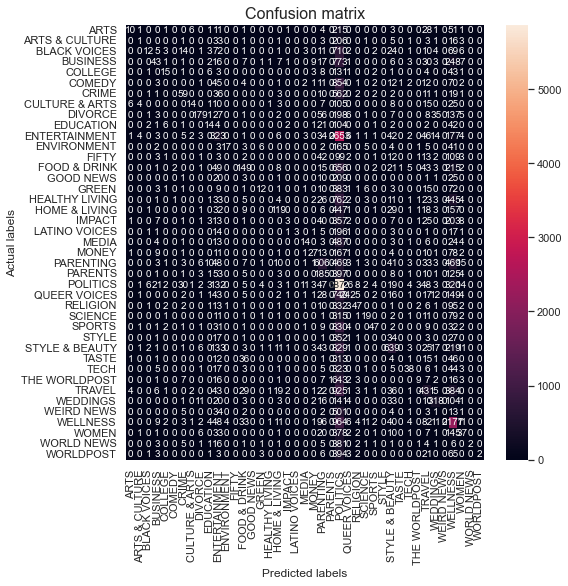

In [6]:
cm = confusion_matrix(
    y_test,
    y_pred
)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title("Confusion matrix", size=16)

In [7]:
sample = df[LABEL].sample(3)
print(sample)



80025           TRAVEL
91601     FOOD & DRINK
135086        POLITICS
Name: Category, dtype: object


Text(0.5, 0, 'Number of ocurrences')

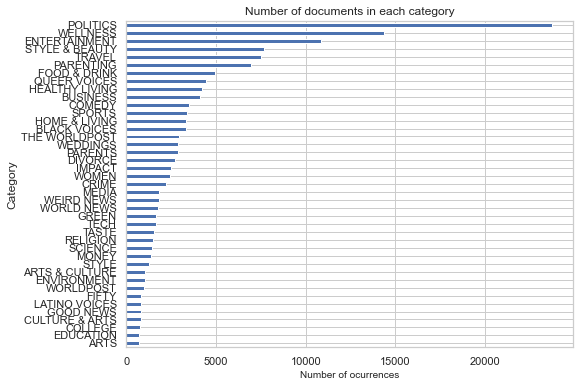

In [8]:
fig = plt.figure(figsize=(8,6))
df.groupby(LABEL)[FEATURES[0]].count().sort_values().plot.barh(
    ylim = 0, 
    title = 'Number of documents in each category'
    )
plt.xlabel('Number of ocurrences', fontsize = 10)